In [1]:
import os
import codecs
import math
import random
import numpy as np
from collections import Counter
import gensim
import pickle
from konlpy import jvm
from gensim.models import FastText
from konlpy.tag import Kkma
import jpype
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [2]:
PAD = "<pad>"
UNK = "<unk>"

In [3]:
def build_fasttext(filename, context_path, target_path, word_dict, verb_dict, dim):
    scale = math.sqrt(3.0 / dim)
    context_emb = np.random.uniform(-scale, scale, [len(word_dict), dim])
    target_emb = np.random.uniform(-scale, scale, [len(verb_dict), dim])
    fasttext_model = FastText.load_fasttext_format(filename, encoding='utf-8')
    
    for word in word_dict:
        idx = word_dict[word]
        context_emb[idx] = fasttext_model.wv[word]
        
    for word in verb_dict:
        idx = verb_dict[word]
        target_emb[idx] = fasttext_model.wv[word]
    
    np.savez_compressed(context_path, embeddings=context_emb)
    np.savez_compressed(target_path, embeddings=target_emb)

In [4]:
def build_vocab(example_dict_pkl, word_threshold=5):
    tokenizer = Kkma()
    word_counter, verb_counter = Counter(), Counter()
    example_dict = dict()
    with open(example_dict_pkl, 'rb') as f:
        example_dict = pickle.load(f)
    
    for word, example in example_dict.items():
        sentence = example[0] + word + example[1]
        verb_counter[word] += 1
        for x in tokenizer.pos(sentence):
            if x[0] in example_dict.keys():
                verb_counter[x[0]] += 1
            else:
                word_counter[x[0]] += 1
    
    # build word vocabulary
    word_vocab = [PAD] + [word for word, count in word_counter.most_common() if count >= word_threshold] + [UNK]
    verb_vocab = [word for word, count in verb_counter.most_common()]
    
    # save to file
    with open('vocabulary/word_vocab.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(word_vocab))
    with open("vocabulary/verb_vocab.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(verb_vocab))
    with open("vocabulary/verb_count.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(["{}\t{}".format(word, count) for word, count in verb_counter.most_common()]))

In [5]:
def load_verb_count(filename):
    count_list = []
    with codecs.open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip().split('\t')
            count = int(line[1])
            count_list.append(count)
    return count_list

In [6]:
def read_vocab_to_dict(filename):
    vocab = dict()
    with open(filename, mode='r', encoding='utf-8') as f:
        for idx, word in enumerate(f):
            word = word.strip()
            vocab[word] = idx
    return vocab

In [88]:
def pad_sequence(sequence, pad_tok=0, max_length=None):
    if max_length is None:
        max_length = max([len(seq) for seq in sequence])
    sequence_padded, seq_length = [], []
    for seq in sequence:
        seq_ = seq[:max_length] + [pad_tok] * max(max_length-len(seq), 0)
        sequence_padded.append(seq_)
        seq_length.append(min(len(seq), max_length))
    return sequence_padded, seq_length

In [8]:
def build_batch_dataset(left_context, verbs, right_context):
    left_context, left_seq_len = pad_sequence(left_context)
    right_context, right_seq_len = pad_sequence(right_context)
    batch_size = len(verbs)
    return {
        'lc': left_context,
        'll': left_seq_len,
        'rc': right_context,
        'rl': right_seq_len,
        'vb': verbs,
        'batch_size': batch_size
    }

In [9]:
def dataset_iterator(example_dict, word_dict, verb_dict, batch_size):
    tokenizer = Kkma()
    left_context, verbs, right_context = [], [], []
    for word, example in example_dict.items():
        # split data
        l_c, vb, r_c = example[0], word, example[1]
        # convert to indices
        l_c = [word_dict[word[0]] if word[0] in word_dict else word_dict[UNK] for word in tokenizer.pos(l_c)]
        vb = verb_dict[vb]
        r_c = [word_dict[word[0]] if word[0] in word_dict else word_dict[UNK] for word in tokenizer.pos(r_c)]
        # add to list
        left_context.append(l_c)
        verbs.append(vb)
        right_context.append(r_c)
        # yield batched dataset
        if len(left_context) == batch_size:
            yield build_batch_dataset(left_context, verbs, right_context)
            left_context, verbs, right_context = [], [], []
    if len(left_context) > 0:
        yield build_batch_dataset(left_context, verbs, right_context)

In [10]:
tokenizer = Kkma()
word_counter, verb_counter = Counter(), Counter()
example_dict = dict()
with open('vocabulary/example_dict.pkl', 'rb') as f:
    example_dict = pickle.load(f)

In [11]:
len(example_dict)

8270

In [12]:
for word, example in example_dict.items():
    sentence = example[0] + word + example[1]
    verb_counter[word] += 1
    for x in tokenizer.pos(sentence):
        if x[0] in example_dict.keys():
            verb_counter[x[0]] += 1
        else:
            word_counter[x[0]] += 1

In [13]:
len(verb_counter), len(example_dict)

(8270, 8270)

In [14]:
len(word_counter)

10547

In [15]:
word_threshold = 5

In [16]:
# build word vocabulary
word_vocab = [PAD] + [word for word, count in word_counter.most_common() if count >= word_threshold] + [UNK]
verb_vocab = [word for word, count in verb_counter.most_common()]

In [18]:
word_vocab = '\n'.join(word_vocab)
verb_vocab = '\n'.join(verb_vocab)
verb_count = '\n'.join((["{}\t{}".format(word, count) for word, count in verb_counter.most_common()]))

In [19]:
def read_vocab_to_dict(text):
    vocab = {}
    for idx, word in enumerate(text.split('\n')):
        word = word.lstrip().rstrip()
        vocab[word] = idx
    return vocab

In [20]:
word_dict = read_vocab_to_dict(word_vocab)
verb_dict = read_vocab_to_dict(verb_vocab)

In [21]:
len(word_dict), len(verb_dict)

(1574, 8270)

In [22]:
def load_verb_count(text):
    count_list = []
    for line in text.split('\n'):
        line = line.strip().split('\t')
        count = int(line[1])
        count_list.append(count)
    return count_list

In [23]:
verb_vocab_count = load_verb_count(verb_count)

In [24]:
len(verb_vocab_count)

8270

In [25]:
filename = 'wiki.ko.bin'
# context_path = 'embeddings/context_embeddings.npz'
# target_path = 'embeddings/target_embeddings.npz'
dim = 300

In [26]:
scale = np.sqrt(3.0 / dim)
context_emb = np.random.uniform(-scale, scale, [len(word_dict), dim])
target_emb = np.random.uniform(-scale, scale, [len(verb_dict), dim])

In [27]:
filename

'wiki.ko.bin'

https://fasttext.cc/docs/en/pretrained-vectors.html

In [28]:
fasttext_model = FastText.load_fasttext_format(filename, encoding='utf-8')

C:\Users\jinma\AppData\Local\Continuum\anaconda3\envs\basic\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.


In [29]:
for word, idx in word_dict.items():
    context_emb[idx] = fasttext_model.wv[word]
    
for word, idx in verb_dict.items():
    target_emb[idx] = fasttext_model.wv[word]   

In [30]:
import tensorflow as tf
import os
import numpy as np
import pickle

In [31]:
# https://dongjinlee.tistory.com/entry/선택한-GPU에만-메모리-할당하는-방법
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # 나는 하나만 사용, ksenticnet에선 "0,1"로 사용

In [32]:
example_dict = dict()
with open('vocabulary/example_dict.pkl', 'rb') as f:
    example_dict = pickle.load(f) # 이 파일은 어디에서 왔을까?

In [33]:
# def read_vocab_to_dict(filename):
#     vocab = dict()
#     with open(filename, mode='r', encoding='utf-8') as f:
#         for idx, word in enumerate(f):
#             word = word.strip()
#             vocab[word] = idx
#     return vocab

# # data_helper.py에서 실행할 결과와 사뭇 다르다.
# # 일단 돌아가는 것을 확인하고 어떻게 해결할 지 고민한다.
# word_dict = read_vocab_to_dict("vocabulary/word_vocab.txt")
# verb_dict = read_vocab_to_dict("vocabulary/verb_vocab.txt")
# verb_vocab_count = load_verb_count("vocabulary/verb_count.txt")

In [34]:
len(word_dict), len(verb_dict), len(verb_vocab_count)

(1574, 8270, 8270)

In [35]:
flags = tf.flags
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_integer("neg_sample", 10, "number of negative samples")
flags.DEFINE_integer("word_dim", 300, "word embedding dimension")
flags.DEFINE_integer("num_units", 100, "number of units for rnn cell and hidden layer of ffn")
flags.DEFINE_integer("output_units", 200, "number of units for output part")
flags.DEFINE_bool("use_pretrained", True, "use pretrained word2vec")
flags.DEFINE_bool("tune_emb", True, "tune pretrained embeddings while training")
flags.DEFINE_string("pretrained_context", "embeddings/context_embeddings.npz", "pretrained context embedding path")
flags.DEFINE_string("pretrained_target", "embeddings/target_embeddings.npz", "pretrained target embedding path")
flags.DEFINE_integer("vocab_size", len(word_dict), "word vocab size")
flags.DEFINE_integer("verb_size", len(verb_dict), "verb vocab size")
flags.DEFINE_float("lr", 0.001, "learning_rate")
flags.DEFINE_integer("batch_size", 300, "batch size")
flags.DEFINE_integer("epochs", 3, "epochs")
flags.DEFINE_string("ckpt", "ckpt/", "checkpoint path")
flags.DEFINE_string("model_name", "train_concept", "model name")
config = flags.FLAGS

In [36]:
flags.DEFINE_string('fasttext_path', 'wiki.ko.bin', 'model file for create')

In [37]:
not os.path.exists(config.pretrained_context) or not os.path.exists(config.pretrained_target)

False

In [38]:
filename, context_path, target_path, word_dict, verb_dict, dim = (
    config.fasttext_path, config.pretrained_context, config.pretrained_target,
    word_dict, verb_dict, config.word_dim)

In [39]:
# scale = np.sqrt(3.0 / dim)
# context_emb = np.random.uniform(-scale, scale, [len(word_dict), dim])
# target_emb = np.random.uniform(-scale, scale, [len(verb_dict), dim])
# fasttext_model = FastText.load_fasttext_format(filename, encoding='utf8')

In [40]:
# for word, idx in word_dict.items():
#     context_emb[idx] = fasttext_model.wv[word]
    
# for word, idx in verb_dict.items():
#     target_emb[idx] = fasttext_model.wv[word]

In [41]:
if not os.path.exists(config.ckpt):
    os.makedirs(config.ckpt)

In [42]:
sess_config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)

In [43]:
sess_config.gpu_options.allow_growth = True

In [44]:
from tensorflow.python.ops.rnn_cell import LSTMCell
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn

In [45]:
def self_attention(inputs, name, return_alphas=False):
    shared = False
    hidden_size = inputs.shape[2].value # D value - hidden size of the RNN layer
    if shared:
        scope_name = 'self_attn'
    else:
        scope_name = 'self_attn' + name
    with tf.variable_scope(scope_name):
        den = True
        if den:
            x_proj = tf.layers.Dense(hidden_size)(inputs)
            x_proj = tf.nn.tanh(x_proj)
        else:
            x_proj = inputs
        u_w = tf.Variable(tf.random_normal([hidden_size, 1], stddev=0.01, seed=1227))
        x = tf.tensordot(x_proj, u_w, axes=1)
        alphas = tf.nn.softmax(x, axis=-1)
        output = tf.matmul(tf.transpose(inputs, [0, 2, 1]), alphas)
        output = tf.squeeze(output, -1)
        if not return_alphas:
            return output
        else:
            return output, alphas

In [50]:
def ffn_layer(inputs, hidden_units, output_units, use_bias=True, bias_init=0.,
              activation=tf.nn.tanh, scope='ffn_layer'):
    with tf.variable_scope(scope):
        dim = inputs.get_shape().as_list()[-1]
        # hidden layer
        hidden_weight = tf.get_variable(name='hidden_weight', shape=[dim, hidden_units], dtype=tf.float32)
        hidden_output = tf.matmul(inputs, hidden_weight)
        if use_bias:
            hidden_bias = tf.get_variable(name='hidden_bias', shape=[hidden_units], dtype=tf.float32)
            hidden_output = tf.nn.bias_add(hidden_output, hidden_bias)
        hidden_output = activation(hidden_output)
        # output layer
        weight = tf.get_variable(name='weight', shape=[hidden_units, output_units], dtype=tf.float32)
        output = tf.matmul(hidden_output, weight)
        if use_bias:
            bias = tf.get_variable(name='bias', shape=[output_units], dtype=tf.float32)
            output = tf.nn.bias_add(output, bias)
        output = activation(output)
        return output

In [90]:
class Model:
    def __init__(self, cfg, vocab_counts):
        # add data palceholders
        self.left_context = tf.placeholder(name="left_context", shape=[None, None], dtype=tf.int32)
        self.left_seq_len = tf.placeholder(name="left_seq_len", shape=[None], dtype=tf.int32)
        self.right_context = tf.placeholder(name="right_context", shape=[None, None], dtype=tf.int32)
        self.right_seq_len = tf.placeholder(name="right_seq_len", shape=[None], dtype=tf.int32)
        self.verb = tf.placeholder(name="verb", shape=[None], dtype=tf.int32)
        
        # add hyper-parameter placeholders
        self.batch_size = tf.placeholder(name="batch_size", dtype=tf.int32)
        self.is_train = tf.placeholder(name="is_train", shape=[], dtype=tf.bool)
        self.drop_rate = tf.placeholder(name="dropout_rate", dtype=tf.float32)
        self.lr = tf.placeholder(name="learning_rate", dtype=tf.float32)
        
        # build embedding lookup table
        with tf.device("/gpu:0"):
            with tf.variable_scope("context_lookup_table"):
                self.word_embeddings = tf.Variable(np.load(cfg.pretrained_context)["embeddings"],
                                                   name="word_embeddings",
                                                   dtype=tf.float32,
                                                   trainable=cfg.tune_emb)
                self.word_embeddings = tf.concat([tf.zeros([1, cfg.word_dim]), 
                                                  self.word_embeddings[1:, :]], axis=0)

            with tf.variable_scope("target_lookup_table"):
                self.verb_embeddings = tf.Variable(np.load(cfg.pretrained_target)["embeddings"],
                                                   name="verb_embeddings",
                                                   dtype=tf.float32,
                                                   trainable=cfg.tune_emb)
#                 self.verb_embeddings = tf.concat([tf.zeros([1, cfg.word_dim]), 
#                                                  self.verb_embeddings[1:, :]], axis=0)

            # negative sampling
            self.neg_ids, _, _ = (tf.nn.fixed_unigram_candidate_sampler(
                true_classes=tf.cast(tf.expand_dims(self.verb, axis=1), dtype=tf.int64),
                num_true=1,
                num_sampled=cfg.neg_sample, # 10개 뽑아서 추출
                unique=True,
                range_max=cfg.verb_size,
                distortion=0.75,
                unigrams=vocab_counts))

            print('neg_ids : ', self.neg_ids)
        
            # Embedding lookup
            # with tf.device("\gpu:0"):
            with tf.variable_scope('embedding_lookup'):
                left_context_emb = tf.nn.embedding_lookup(self.word_embeddings, self.left_context)
                right_context_emb = tf.nn.embedding_lookup(self.word_embeddings, self.right_context)
                verb_emb = tf.nn.embedding_lookup(self.verb_embeddings, self.verb)
                neg_verb_emb = tf.nn.embedding_lookup(self.verb_embeddings, self.neg_ids)
            
        # left context bi-lstm
        with tf.device('/gpu:0'):
            with tf.variable_scope('right_context_representation'):
                cell_fw = LSTMCell(num_units=cfg.num_units)
                cell_bw = LSTMCell(num_units=cfg.num_units)
                h_rc, _ = bidirectional_dynamic_rnn(cell_fw, cell_bw, right_context_emb,
                                                    sequence_length=self.right_seq_len,
                                                    dtype=tf.float32,
                                                    time_major=False,
                                                    scope='bi-lstm')
                h_rc = tf.concat(h_rc, axis=-1)
                # self-attention
                h_rc = self_attention(h_rc, name='self_attn_right')
                r_weight = tf.get_variable(name='r_weight',
                                           shape=[2 * cfg.num_units, 2 * cfg.num_units],
                                           dtype=tf.float32)
                h_rc = tf.nn.tanh(tf.matmul(h_rc, r_weight))
                print('right context shape: {}'.format(h_rc.get_shape().as_list()))

            with tf.variable_scope('left_context_representation'):
                cell_fw = LSTMCell(num_units=cfg.num_units)
                cell_bw = LSTMCell(num_units=cfg.num_units)
                h_lc, _ = bidirectional_dynamic_rnn(cell_fw, cell_bw, left_context_emb,
                                                    sequence_length=self.left_seq_len,
                                                    dtype=tf.float32,
                                                    time_major=False,
                                                    scope='bi-lstm')
                h_lc = tf.concat(h_lc, axis=-1)
                # self-attention
                h_lc = self_attention(h_lc, name='self_attn_left')
                l_weight = tf.get_variable(name='l_weight',
                                           shape=[2 * cfg.num_units, 2 * cfg.num_units],
                                           dtype=tf.float32)
                h_lc = tf.nn.tanh(tf.matmul(h_lc, l_weight))
                print('left context shape: {}'.format(h_lc.get_shape().as_list()))
                
            with tf.variable_scope('neural_tensor_network'):
                T = tf.get_variable(name='T',
                                    shape=[cfg.output_units, 2*cfg.num_units, 2*cfg.num_units],
                                    dtype=tf.float32)
                W = tf.get_variable(name='W',
                                    shape=[4*cfg.num_units, cfg.output_units],
                                    dtype=tf.float32)
                b = tf.get_variable(name='b',
                                    shape=[cfg.output_units],
                                    dtype=tf.float32)
                # compute tensors
                ff_product = tf.matmul(tf.concat([h_lc, h_rc], axis=-1), W)
                bilinear_list = []
                for k in range(cfg.output_units):
                    cur_res = tf.reduce_sum(tf.matmul(h_lc, T[k]) * h_rc, axis=1)
                    bilinear_list.append(cur_res)
                context = tf.nn.tanh(tf.reshape(tf.concat(bilinear_list, axis=0), shape=[-1, cfg.output_units]) +
                                     ff_product + b) # shape = (batch_size, output_units)
                
            with tf.variable_scope('verb_representation'):
                target_verb = ffn_layer(verb_emb, cfg.num_units, cfg.output_units, scope='ffn_layer')
                print('verb representation shape: {}'.format(target_verb.get_shape().as_list()))
                tf.get_variable_scope().reuse_variables()
                negative_verbs = ffn_layer(
                    inputs=neg_verb_emb, 
                    hidden_units=cfg.num_units, 
                    output_units=cfg.output_units, 
                    use_bias=True, 
                    bias_init=0.,
                    activation=tf.nn.tanh,
                    scope='ffn_layer')
                print('negative verb shape: {}'.format(negative_verbs.get_shape().as_list()))
                
            with tf.variable_scope('compute_loss'):
                true_logits = tf.reduce_sum(context * target_verb, axis=1)
                print('true logits shape: {}'.format(true_logits.get_shape().as_list()))
                neg_logits = tf.matmul(context, tf.transpose(negative_verbs, [1, 0]))
                print('negative logits shape: {}'.format(neg_logits.get_shape().as_list()))
                
            with tf.variable_scope('nce_loss'):
                true_xent = tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logits,
                                                                    labels=tf.ones_like(true_logits))
                sampled_xent = tf.nn.sigmoid_cross_entropy_with_logits(logits=neg_logits,
                                                                       labels=tf.ones_like(neg_logits))
                
                # NCE-loss is the sum of the true and noise (sampled words) contributions, averaged over the batch
                self.loss = ((tf.reduce_sum(true_xent) + tf.reduce_sum(sampled_xent)) / 
                             tf.cast(self.batch_size, dtype=tf.float32))
                
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
            self.train_op = optimizer.minimize(self.loss)
            
    def get_feed_dict(self, data, is_train=False, drop_rate=0.0, lr=None):
        feed_dict = {
            self.verb: data['vb'],
            self.left_context: data['lc'],
            self.left_seq_len: data['ll'],
            self.right_context: data['rc'],
            self.right_seq_len: data['rl'],
            self.batch_size: data['batch_size']
        }
        if lr is not None:
            feed_dict[self.lr] = lr
        feed_dict[self.is_train] = is_train
        feed_dict[self.drop_rate] = drop_rate
        return feed_dict

In [92]:
sess = tf.Session(config=sess_config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5



In [93]:
model = Model(config, verb_vocab_count)

neg_ids :  Tensor("FixedUnigramCandidateSampler:0", shape=(10,), dtype=int64, device=/device:GPU:0)
right context shape: [None, 200]
left context shape: [None, 200]
verb representation shape: [None, 200]
negative verb shape: [10, 200]
true logits shape: [None]
negative logits shape: [None, 10]


In [94]:
sess.run(tf.global_variables_initializer())

In [95]:
saver = tf.train.Saver(max_to_keep=1)

In [78]:
# tokenizer = Kkma()
# left_context, verbs, right_context = [], [], []
# for word, example in example_dict.items():
#     l_c, vb, r_c = example[0], word, example[1]
#     l_c = [word_dict[word[0]] if word[0] in word_dict else word_dict[UNK] for word in tokenizer.pos(l_c)]
#     vb = verb_dict[vb]
#     r_c = [word_dict[word[0]] if word[0] in word_dict else word_dict[UNK] for word in tokenizer.pos(r_c)]
#     left_context.append(l_c)
#     verbs.append(vb)
#     right_context.append(r_c)

In [79]:
len(left_context), len(verbs), len(right_context)

(8270, 8270, 8270)

In [80]:
config.batch_size

300

In [83]:
pad_tok = 0

In [84]:
# max_length = max([len(seq) for seq in left_context[:300]])
# left_context_, left_seq_len = [], []
# for seq in left_context[:300]:
#     seq_ = seq[:max_length] + [pad_tok] * max(max_length - len(seq), 0)
#     left_context_.append(seq_)
#     left_seq_len.append(min(len(seq), max_length))
    
# max_length = max([len(seq) for seq in right_context[:300]])
# right_context_, right_seq_len = [], []
# for seq in left_context[:300]:
#     seq_ = seq[:max_length] + [pad_tok] * max(max_length - len(seq), 0)
#     right_context_.append(seq_)
#     right_seq_len.append(min(len(seq), max_length))
    
# batch_size = len(verbs[:300])

# feed_dict = {
#     'lc': left_context_,
#     'll': left_seq_len,
#     'rc': right_context_,
#     'rl': right_seq_len,
#     'vb': verbs,
#     'batch_size': batch_size
# }

In [96]:
for epoch in range(config.epochs):
    print('\repoch :', epoch, end='')
    data_iter = dataset_iterator(example_dict, word_dict, verb_dict, config.batch_size)
    for (i, data) in enumerate(data_iter):
        feed_dict = model.get_feed_dict(data, is_train=True, lr=config.lr)
        _, losses = sess.run([model.train_op, model.loss], feed_dict=feed_dict)

epoch : 0
epoch : 1
epoch : 2


In [98]:
saver.save(sess, config.ckpt + config.model_name, global_step=config.epochs)
target_emb = sess.run(model.verb_embeddings)

In [101]:
target_emb

array([[-0.6489587 ,  0.22590488, -1.1362432 , ..., -0.0087962 ,
         0.44888574, -0.3660209 ],
       [-0.72890246,  0.20910072, -0.7256731 , ...,  0.29167625,
         0.17341195, -0.37546793],
       [-0.5749987 ,  0.15455553, -0.6885311 , ...,  0.3039003 ,
         0.16293989, -0.5774864 ],
       ...,
       [-0.31256592,  0.13482359, -0.1201131 , ..., -0.03876929,
         0.13180208, -0.38239166],
       [-0.14058445,  0.05386894, -0.19620898, ...,  0.16196038,
         0.08151963, -0.01439535],
       [-0.17340818,  0.10849348, -0.07742525, ...,  0.00275804,
         0.0862994 , -0.24823163]], dtype=float32)

In [102]:
sess.close()
tf.reset_default_graph()

In [105]:
from senticnet5 import senticnet
import nltk
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import numpy as np
import math
import pickle
from wordfreq import word_frequency

In [106]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jinma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [107]:
class Hypernyms:
    def __init__(self, word, synset_obj):
        self.level = [[], [], [], []]
        self.level[0] = [lemma.name().lower() for lemma in synset_obj.lemmas()]
        self.level[0].remove(word)
        l1, l2, l3 = [], [], []
        l1 = synset_obj.hypernyms()
        for hyper in l1:
            self.level[1] += [lemma.name().lower() for lemma in hyper.lemmas()]
            l2 += hyper.hypernyms()
        for hyper in l2:
            self.level[2] += [lemma.name().lower() for lemma in hyper.lemmas()]
            l3 += hyper.hypernyms()
        for hyper in l3:
            self.level[3] += [lemma.name().lower() for lemma in hyper.lemmas()]

In [108]:
def weighted_sentic(sv1, fr1, sv2, fr2):
    polarity = sv1[6]
    
    tf = fr1 + fr2
    fr1 /= tf
    fr2 /= tf
    
    pl = float(sv1[0]) * fr1 + float(sv2[0]) * fr2
    at = float(sv1[1]) * fr1 + float(sv2[1]) * fr2
    se = float(sv1[2]) * fr1 + float(sv2[2]) * fr2
    ap = float(sv1[3]) * fr1 + float(sv2[3]) * fr2
    pv = float(sv1[7]) * fr1 + float(sv2[7]) * fr2
    
    sentic = [pl, at, se, ap]
    
    return [round(pl, 3), rount(at, 3), round(se, 3), round(ap, 3)] + sentic_to_sentiments(sentic) + [polarity, round(pv, 3)]

In [109]:
def sentic_to_sentiments(sentic):
    sentiment_dict = {
        0 : ['#sadness', '#joy'],
        1 : ['#surprise', '#interest'],
        2 : ['#fear', '#anger'],
        3 : ['#disgust', '#admiration']
    }
    first_sentic, second_sentic = np.argsort(np.absolute(sentic))[-2:][::-1]
    col1 = math.floor(sentic[first_sentic]) + 1
    col2 = math.floor(sentic[second_sentic]) + 1
    
    return [sentiment_dict[first_sentic][col1], sentiment_dict[second_sentic][col2]]

In [110]:
def sentic_to_strin(sentic_value):
    string = ''
    for s in sentic_value:
        string += "'" + str(s) + "', "
    return string[:-2]

In [111]:
def load_korean_wordnet_offset(kw_path):
    kw_offset = []
    with open(kw_path, 'r', encoding='utf-8') as f:
        for line in f.read().split('\n')[1:]:
            kw_offset.append(line.split('\t')[0])
    return kw_offset

In [121]:
def load_similarities(trained_target_emb):
#     trained_target_emb = np.load(open(trained_emb_path, 'rb'))['embeddings']
    _sparse = sparse.csr_matrix(trained_target_emb)
    similarities = cosine_similarity(_sparse)
    return similarities

In [113]:
def read_vocab_to_dict(filename):
    vocab = dict()
    with open(filename, mode='r', encoding='utf-8') as f:
        for idx, word in enumerate(f):
            word = word.strip()
            vocab[word] = idx
    return vocab

In [114]:
def index_to_word(word_dict):
    idx_word = dict()
    for word, idx in word_dict.items():
        idx_word[idx] = word
    return idx_word

In [116]:
print('direct mappint started...')

direct mappint started...


In [117]:
ksenticnet = dict()
similarity_dict = dict()

In [122]:
similarity_matrix = load_similarities(target_emb)

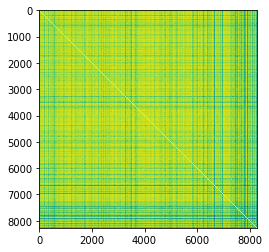

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(similarity_matrix)

In [128]:
word_idx = word_dict

In [129]:
idx_word = index_to_word(word_idx)

In [132]:
korean_wordnet_path = 'kwn_1.0/kwn_synset_list.tsv'

In [134]:
# step 1: make word-synset dict
word_synset_dict = dict()
with open(korean_wordnet_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')[1:]
    for line in lines:
        words = line.split('\t')[2].replace(' ', '').split(',')
        offset = line.split('\t')[0]
        for word in words:
            if word not in word_synset_dict:
                word_synset_dict[word] = [offset]
            else:
                word_synset_dict[word].append(offset)

In [137]:
# step 2: make synset-sentic dict
with open('vocabulary/affectnet_dict.pkl', 'rb') as f:
    aff_fr_dict = pickle.load(f)
fr_offset_dict = dict()
offset_sentic_dict = dict()
deleted_offset = []

In [151]:
print(word_synset_dict['whole'])
synsets = [
    wn.synset_from_pos_and_offset(synset_id[-1], int(synset_id[:8].lstrip('0'))) 
    for synset_id in word_synset_dict['whole']]
synsets

['00003553-n', '05869584-n']


[Synset('whole.n.02'), Synset('whole.n.01')]

In [154]:
[Hypernyms('whole', synset) for synset in synsets]

[<__main__.Hypernyms at 0x21ebc3ba8d0>, <__main__.Hypernyms at 0x21ebc3ba550>]

In [162]:
[lemma.name().lower() for lemma in synsets[0].lemmas()]

['whole', 'unit']

In [163]:
l1 = synsets[0].hypernyms()
l1

[Synset('object.n.01')]

In [167]:
[lemma.name().lower() for lemma in l1[0].lemmas()]

['object', 'physical_object']

In [ ]:
for word in word_synset_dict:
    if word not in senticnet:
        continue
    found = False
    synsets = [wn.synset_from_pos_and_offset(synset_id[-1], int(synset_id[:8].lstrip('0')))
               for synset_id in word_synset_dict[word]]
    num_synsets = len(synsets)
    hypernyms = [Hypernyms(word, synset) for synset in synsets]
    for i in range(4): # hypernyms levels
        for j in range(num_synsets):
            offset = word_synset_dict[word][j]
            if offset in deleted_offset:
                continue
            for hypernym in hypernyms[j].level[i]:
                if hypernym not in senticnet[word]:
                    continue
                
                # hypernym is in semantics so, the synset could the meaning of the word
                if offset not in offset_sentic_dict:
                    offset_sentic_dict[offset] = sentic
                        